C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Pred

Training Set Metrics (SARIMAX):
{'RMSE': 1856.1248609124837, 'MSE': 3445199.499297387, 'MAE': 1637.1746140870075, 'MAPE': 137.88986323284163}

Validation Set Metrics (SARIMAX):
{'RMSE': 1857.4949376358252, 'MSE': 3450287.443342718, 'MAE': 1647.0786446905272, 'MAPE': 122.55075771530184}


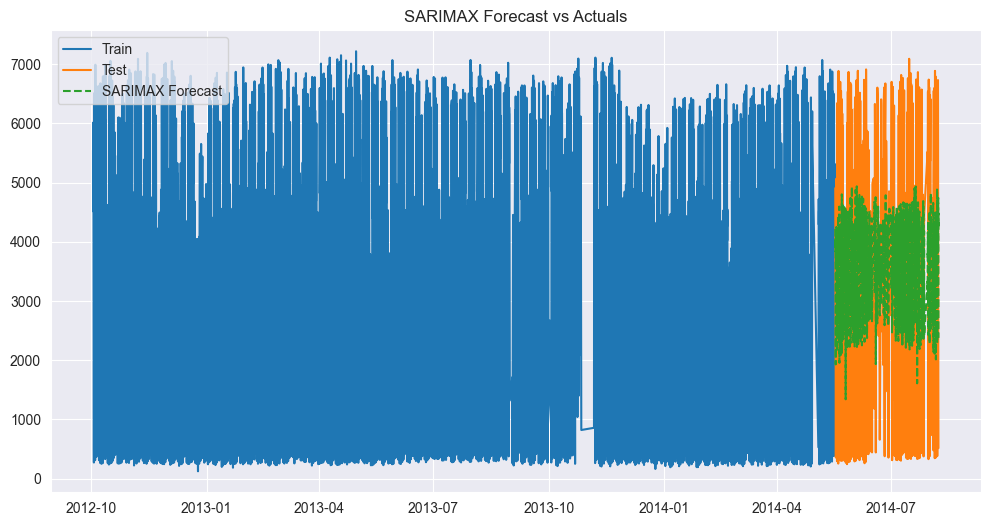

['sarimax_model.joblib']

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import joblib
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
import joblib

# Custom wrapper for SARIMAX
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24)):
        self.order = order
        self.seasonal_order = seasonal_order
    
    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=False)
        return self

    def predict(self, X):
        return self.results.get_forecast(steps=len(X), exog=X).predicted_mean
    
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100


# Load the dataset
df_raw = pd.read_csv('../../train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

end_of_A = '2014-08-08 01:00:00'
df_period_A = df_raw[df_raw['date_time'] <= end_of_A]

# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate
agg_funcs = {col: 'mean' for col in df_period_A.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})
df_aggregated = df_period_A.groupby('date_time').agg(agg_funcs)

# One-hot encode categorical features
df = pd.get_dummies(df_aggregated, columns=non_numeric_cols, drop_first=True)

# Add hour from the index
df['hour'] = df.index.hour

# Split the dataset into features (X) and the target (y)
target = 'traffic_volume'
X = df.drop(target, axis=1)
y = df[target]

# Define a split index for a 90-10 train-test split
split_index = int(len(df) * 0.9)

# Split data
y_train = y.iloc[:split_index]
X_train = X.iloc[:split_index]
y_test = y.iloc[split_index:]
X_test = X.iloc[split_index:]

X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Adjusted parameter grid
param_grid = {
    'order': [(p, d, q) for p in range(0, 3) for d in range(0, 2) for q in range(0, 3)],
    'seasonal_order': [(p, d, q, 12) for p in range(0, 2) for d in range(0, 2) for q in range(0, 2)]
}

# Create the SARIMAX wrapper instance
sarimax = SARIMAXWrapper()

# Initialize RandomizedSearchCV with reduced iterations and cross-validation folds
random_search = RandomizedSearchCV(sarimax, param_distributions=param_grid, n_iter=30, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the RandomizedSearchCV to find the best model
random_search.fit(X_train, y_train)

# Use the best estimator to make predictions
best_sarimax = random_search.best_estimator_
predicted_traffic_volume_sarimax = best_sarimax.predict(X_test)

# Evaluate metrics
def evaluate_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mape_scorer(y_true, y_pred)
    }

train_metrics_sarimax = evaluate_metrics(y_train, best_sarimax.predict(X_train))
val_metrics_sarimax = evaluate_metrics(y_test, predicted_traffic_volume_sarimax)

# Print and compare metrics for SARIMAX
print("Training Set Metrics (SARIMAX):")
print(train_metrics_sarimax)

print("\nValidation Set Metrics (SARIMAX):")
print(val_metrics_sarimax)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, predicted_traffic_volume_sarimax, label='SARIMAX Forecast', linestyle='--')
plt.legend()
plt.title('SARIMAX Forecast vs Actuals')
plt.show()

# Save the trained SARIMAX model
joblib.dump(best_sarimax, 'sarimax_model.joblib')

C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


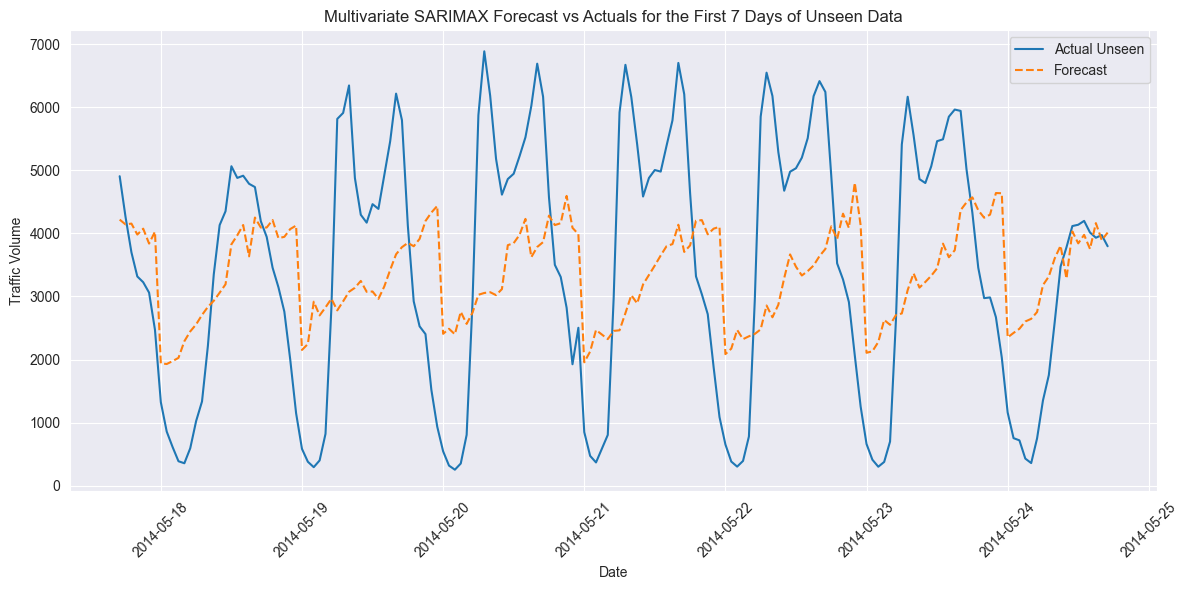

In [2]:
# Make predictions on the first 7 days of unseen data
forecast_unseen = best_sarimax.results.get_forecast(steps=7 * 24, exog=X_test.iloc[:7 * 24])
predicted_traffic_volume_unseen = forecast_unseen.predicted_mean

# Evaluate metrics on the unseen data for SARIMAX
unseen_metrics_sarimax = evaluate_metrics(y_test.iloc[:7 * 24], predicted_traffic_volume_unseen)

# Visualization for the first 7 days of unseen data
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:7 * 24], y_test.iloc[:7 * 24], label='Actual Unseen')
plt.plot(y_test.index[:7 * 24], predicted_traffic_volume_unseen, label='Forecast', linestyle='--')
plt.legend()
plt.title('Multivariate SARIMAX Forecast vs Actuals for the First 7 Days of Unseen Data')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

                date_time  actual_traffic_volume  forecasted_traffic_volume
12508 2014-05-17 17:00:00                 4906.0                4218.474690
12509 2014-05-17 18:00:00                 4258.0                4141.350136
12510 2014-05-17 19:00:00                 3699.0                4155.262443
12511 2014-05-17 20:00:00                 3317.0                3980.858854
12512 2014-05-17 21:00:00                 3226.0                4074.410499
...                   ...                    ...                        ...
13223 2014-07-05 04:00:00                  319.0                2722.461368
13224 2014-07-05 05:00:00                  623.0                2814.376063
13225 2014-07-05 06:00:00                 1118.0                3003.182315
13226 2014-07-05 07:00:00                 1452.0                3022.936327
13227 2014-07-05 08:00:00                 2019.0                3106.450945

[720 rows x 3 columns]


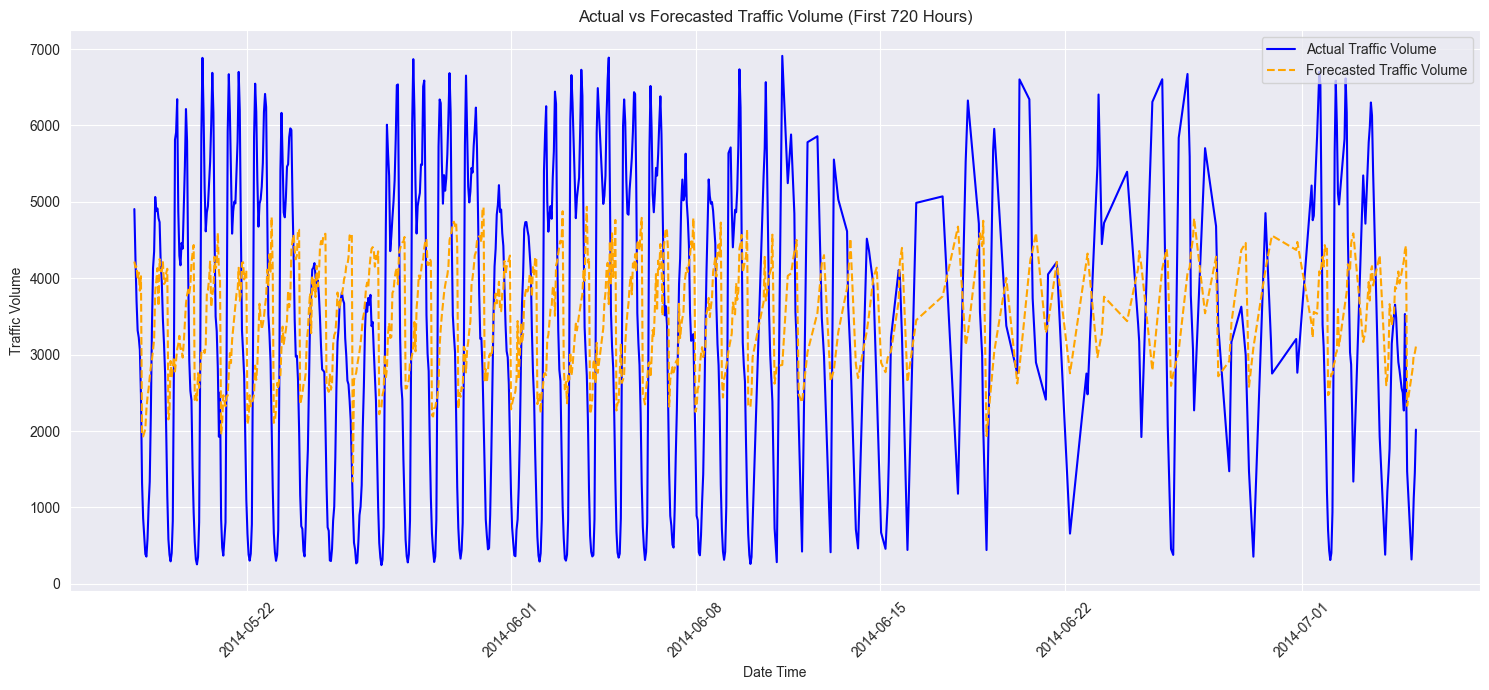

In [3]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'date_time': y_test.index[:720],
    'actual_traffic_volume': y_test.iloc[:720].values,
    'forecasted_traffic_volume': predicted_traffic_volume_sarimax[:720]
})

# Display the DataFrame
print(comparison_df)

# Visualization
plt.figure(figsize=(15, 7))
plt.plot(comparison_df['date_time'], comparison_df['actual_traffic_volume'], label='Actual Traffic Volume', color='blue')
plt.plot(comparison_df['date_time'], comparison_df['forecasted_traffic_volume'], label='Forecasted Traffic Volume', color='orange', linestyle='--')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Forecasted Traffic Volume (First 720 Hours)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()